# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

2025-03-02 21:03:10.864961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## load images and labels
    # FILL IN CODE HERE #  
    # Initialize empty lists to store images and labels
    images = []
    labels = []
    
    # Get the subdirectories (class names) in the provided path
    class_names = os.listdir(path_to_data)
    
    for class_name in class_names:
        # Get the path of the current class directory
        class_path = os.path.join(path_to_data, class_name)
        
        # Only process directories (ignore files in the main directory)
        if os.path.isdir(class_path):
            # Get all image files in this class directory
            image_files = os.listdir(class_path)
            
            for image_file in image_files:
                # Get the full image file path
                image_path = os.path.join(class_path, image_file)
                
                # Load the image
                img = load_img(image_path, target_size=(64, 64))  # Resize to 64x64
                # Convert the image to a numpy array
                img_array = img_to_array(img)
                
                # Append the image and its label
                images.append(img_array)
                labels.append(class_name)  # The label is the class name
                
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Encode labels as integers (optional, if needed for training)
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    return images, labels

In [3]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

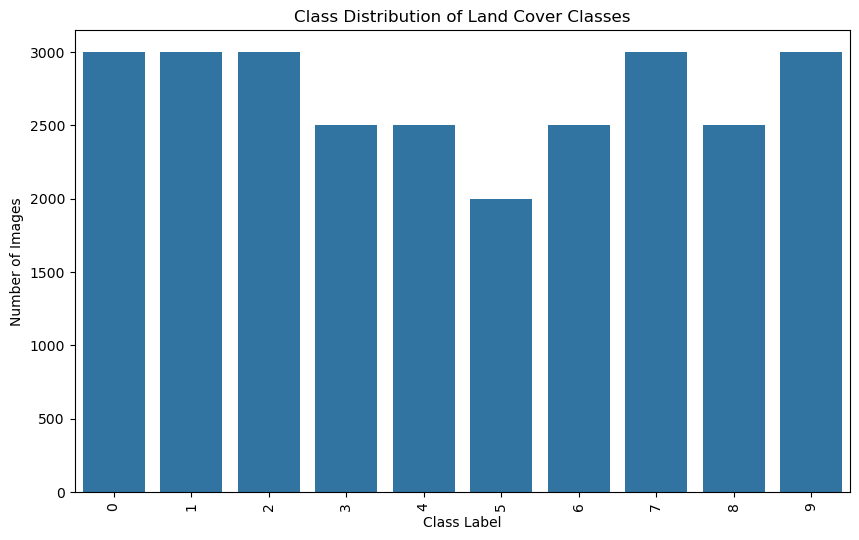

In [4]:
# FILL IN CODE HERE # 
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(labels):
    '''Plot the distribution of the land cover classes.'''
    # Count the occurrences of each label
    class_counts = pd.Series(labels).value_counts()
    
    # Create a bar plot for class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    
    plt.title("Class Distribution of Land Cover Classes")
    plt.xlabel("Class Label")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=90)  # Rotate class labels if needed
    plt.show()

# Call the function with your labels
plot_class_distribution(labels)

Comment on class balance: the bars of all class label have roughly the same height as shown in chart above, the classes appear balanced.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

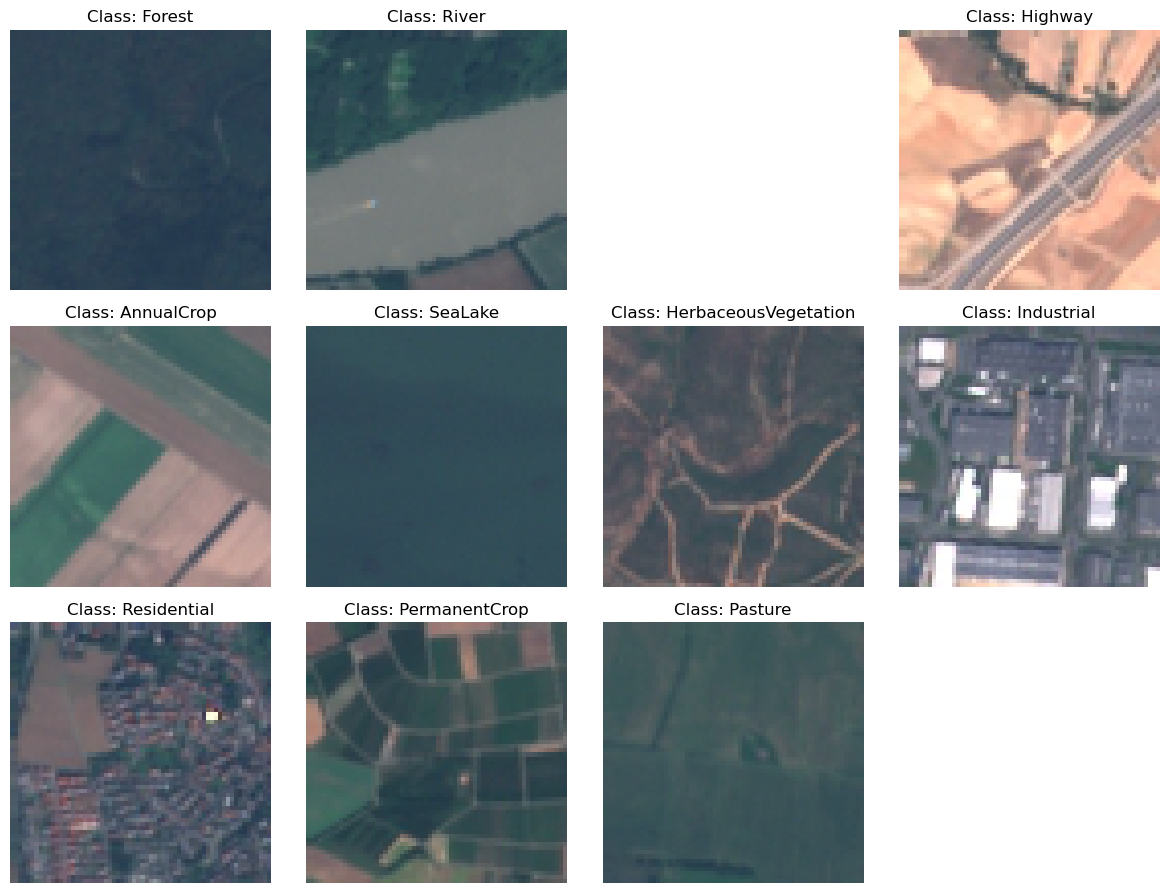

class names ['Forest', 'River', '.DS_Store', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


In [5]:
# FILL IN CODE HERE #
class_names = os.listdir(DATA_PATH)
def display_sample_images(path_to_data):
    '''Display one image from each class.'''
    #class_names = os.listdir(path_to_data)
    
    plt.figure(figsize=(12, 12))  # Set the size of the plot
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(path_to_data, class_name)
        
        if os.path.isdir(class_path):
            # Get the first image in the directory (just for inspection)
            image_files = os.listdir(class_path)
            image_path = os.path.join(class_path, image_files[0])  # Get the first image
            
            # Load and display the image
            img = load_img(image_path, target_size=(64, 64))  # Resize image for uniformity
            img_array = img_to_array(img)
            
            plt.subplot(4, 4, i + 1)  # Arrange images in a grid (adjust the grid size if needed)
            plt.imshow(img_array.astype('uint8'))
            plt.title(f'Class: {class_name}')
            plt.axis('off')  # Turn off axis labels
            
    plt.tight_layout()
    plt.show()

# Display images
display_sample_images(DATA_PATH)
print("class names", class_names[:])


Most confused land classes: Deceision Tree classifier would struggle to distinguish between classes that have visually similar patterns e.g. between Pasture and Forest

---
### Step 3: Data preprocessing

Encode labels

In [6]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

In [7]:
print("mapped encoded label values to class: ", encoded_labels_classes[:])

mapped encoded label values to class:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [8]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # FILL IN CODE HERE #
    indices = np.random.permutation(len(images)) 
    images_shuffled = images[indices]
    labels_shuffled = labels[indices]
    
    # create data splits
    # FILL IN CODE HERE #
    total_samples = len(images)
    train_size = int(total_samples * split[0])
    val_size = int(total_samples * split[1])
    test_size = total_samples - train_size - val_size
    
    # Split the data into train, validation, and test
    X_train = images_shuffled[:train_size]
    y_train = labels_shuffled[:train_size]
    
    X_val = images_shuffled[train_size:train_size + val_size]
    y_val = labels_shuffled[train_size:train_size + val_size]
    
    X_test = images_shuffled[train_size + val_size:]
    y_test = labels_shuffled[train_size + val_size:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [10]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.random_flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    # FILL IN CODE HERE #
    
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): Data Augmentation will help model generalize better by exposing it to wide varierty of image variation by  artificially applying random transformations (such as flipping, adjusting brightness, and contrast).

In [11]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [12]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Training Accuracy: 48.26%
Validation Accuracy: 44.52%


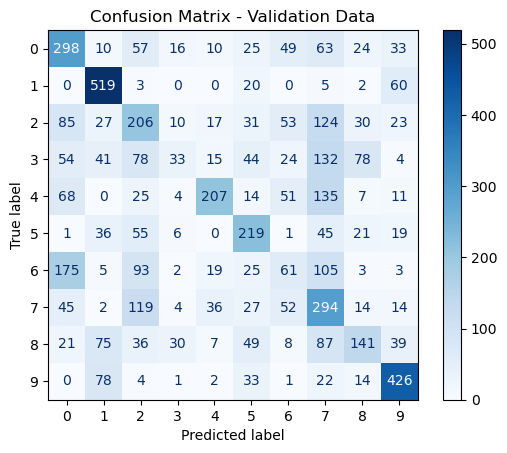


Model Performance Analysis:
The model seems to overfit as the training accuracy is higher than validation accuracy.


In [13]:
### YOUR CODE HERE ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Initialize the RandomForestClassifier with specified hyperparameters
rf_model = RandomForestClassifier(n_estimators=2, n_jobs=1, random_state=7, max_depth=8)

# Step 2: Train the model on the training data
rf_model.fit(X_train_re, y_train)

# Step 3: Predict on both training and validation sets
y_train_pred = rf_model.predict(X_train_re)
y_val_pred = rf_model.predict(X_val_re)

# Step 4: Calculate accuracy on both training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Step 5: Plot confusion matrix for validation data
conf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encoded_labels_classes)

# Plotting the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Data")
plt.show()

# Step 6: Comment on performance
print("\nModel Performance Analysis:")
if train_accuracy > val_accuracy:
    print("The model seems to overfit as the training accuracy is higher than validation accuracy.")
else:
    print("The model generalizes well as the training and validation accuracies are similar.")


Comment on model accuracy on training vs. validation data:
Training Accuracy 48.26% and Validation Accuracy: 44.52% are very close.

Does the model generalize well?: The model generalizes well as the Training and Validation accuracy are very close.

Comment on the classes that the model confuses the most: class 0 and class 6 has the highest value in confusion matrix outside the diaganol values i.e. 175, indicating the model confuses the most between these two class types.

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

Training Accuracy: 58.66%
Validation Accuracy: 49.85%


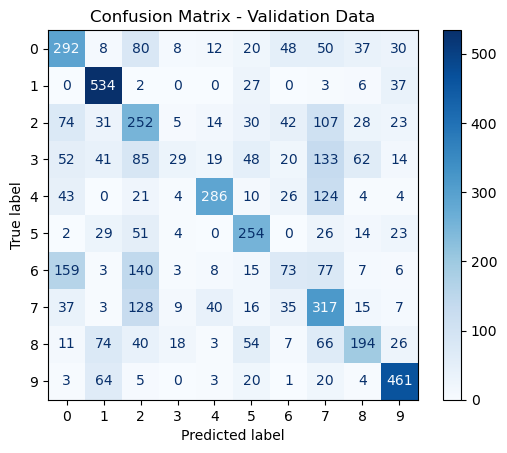


Model Performance Analysis:
The model generalizes well as the performance difference between training and validation is at most 10%.


In [25]:
rf_clf2 = ''
### YOUR CODE HERE ###
#from sklearn.ensemble import GradientBoostingClassifier 
 # import  RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Step 1: Initialize GradientBoostingClassifier with improved hyperparameters
""" gb_model = GradientBoostingClassifier(
    n_estimators=100,   # Increased number of estimators to 100
    learning_rate=0.1,  # Learning rate to control how fast the model learns
    max_depth=10,       # Increased max depth of trees
    min_samples_split=2,  # Minimum samples required to split a node (small value for flexibility)
    random_state=7
) """

rf_clf2 = RandomForestClassifier(
    n_estimators=4,   # Increased number of estimators to 20 from 2
    max_depth=9,       # Increased max depth of trees
    n_jobs=1,
    random_state=7
)
# X_train and X_test are 4D arrays, reshape to 2D
X_train = X_train.reshape(X_train.shape[0], -1)  
X_test = X_test.reshape(X_test.shape[0], -1) 

# Train the GradientBoostingClassifier on the training data
rf_clf2.fit(X_train_re, y_train)

#  Predict on both training and validation sets
y_train_pred = rf_clf2.predict(X_train_re)
y_val_pred = rf_clf2.predict(X_val_re)

#  Calculate accuracy on both training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot confusion matrix for validation data
conf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encoded_labels_classes)

# Plotting the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Data")
plt.show()

# Compare performance with the baseline model
print("\nModel Performance Analysis:")
if abs(train_accuracy - val_accuracy) <= 0.1:
    print("The model generalizes well as the performance difference between training and validation is at most 10%.")
else:
    print("The model may be overfitting or underfitting as the performance difference is more than 10%.")


Baseline model has Training accuracy has 48.26% while this Model has Training Accuracy of 58.66% which is >10% improvement of training accuracy.
With improved Validation Accuracy: of 49.85% vs basedline validation accuracy of 44.52%, there is improvement over baseline model.

How your implementation is different compared to the baseline classifier: compared to baseline model , RandomForestClassifier has increased depth of 9 vs 8 , increased number of estimaters to 4

Comment on training vs. validation performance relative to baseline model: The difference of baseline model training vs validation peformance is ~4% and new model has training vs validation performance difference of 8%.

Comment on the classes the model confuses the most relative to the baseline: both model confuses between class 0 and class 6 the most.

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [15]:
### YOUR CODE HERE ###
from sklearn.metrics import accuracy_score
# If X_train and X_test are 4D arrays, reshape them
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten the 4D array to 2D
X_test = X_test.reshape(X_test.shape[0], -1)  # Flatten the 4D array to 2D

# Step 1: Predict on the test set
y_test_pred = rf_clf2.predict(X_test)

# Step 2: Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 3: Compare with training and validation accuracies
print("\nModel Performance Comparison:")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 59.17%

Model Performance Comparison:
Training Accuracy: 80.14%
Validation Accuracy: 58.61%
Test Accuracy: 59.17%


Comment on test set accuracy vs. training vs. validation set accuracy: 
The model generalizes well, with test and validation accuracies being similar i.e. ~58%

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

### YOUR ANSWER HERE ###
I would recommend decision forest for land cover classification as :
    it is simpler to implement and processes data in parallel.
    this is a good fit to handle high dimensional data which is the case here.
    RandomForestClassifier processes data in parallel unlike Gradient Boosting which is sequential. 
    For faster processing RandomForestClassfier is a good choice. 
    

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

### YOUR ANSWER HERE ###
Convolutional Neural Networks or K Nearest Neighbour model (for small data set) could be a better option for analyzing the spatial data preprocessing.
CNN model would detect visual patterns in the features. This helps the model recognize an object in various positions within the input.



----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [16]:
### YOUR CODE HERE ###